# LSTM part-of-speech tagging for the French Treebank: 

This notebook trains a part-of-speech tagger for the French Treebank using a vanilla bi-direction LSTM network.

Run the following cell to load the Keras packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

from keras.models import Model
from keras.layers import Bidirectional, Dense, Input, Dropout, LSTM, Activation, TimeDistributed, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split

%matplotlib inline

np.random.seed(1)

Using TensorFlow backend.


In [159]:
# normalizes word according to the conventions of fastText; only transforms the word to lower case

def normalize_word(orig_word):
    word = orig_word.lower()
    if (word is "["):
        word = "("
    if (word is "]"):
        word = ")"
    
    return word

In [3]:
def read_maxentdata(file):
    with open(file, 'r') as f:
        vocabulary = set()
        vnorm = set()
        partsofspeech1 = set()
        partsofspeech2 = set()
        superset = set()
        sentno = 0
        maxlen = 0
        words = []
        postags1 = []
        postags2 = []
        supertags = []
        allwords = []
        allpos1 = []
        allpos2 = []
        allsuper = []
        for line in f:
            line = line.strip().split()
            length = len(line)
            if (length > maxlen):
                maxlen = length
            for l in range(length):
                item = line[l].split('|')
                orig_word = item[0]
                word = normalize_word(orig_word)
                postag = item[1]
                supertag = item[2]
                poslist = postag.split('-')
                pos1 = poslist[0]
                pos2 = poslist[1]
                vocabulary.add(orig_word)
                vnorm.add(word)
                partsofspeech1.add(pos1)
                partsofspeech2.add(pos2)
                superset.add(supertag)
                words.append(orig_word)
                postags1.append(pos1)
                postags2.append(pos2)
                supertags.append(supertag)
            allwords.append(words)
            allpos1.append(postags1)
            allpos2.append(postags2)
            allsuper.append(supertags)
            words = []
            postags1 = []
            postags2 = []
            supertags = []
            
        X = np.asarray(allwords)
        Y1 = np.asarray(allpos1)
        Y2 = np.asarray(allpos2)
        Z = np.asarray(allsuper)
        return X, Y1, Y2, Z, vocabulary, vnorm, partsofspeech1, partsofspeech2, superset, maxlen

In [ ]:
# very small initial part of corpus (only file aa1)
# X, Y1, Y2, Z, vocabulary, vnorm, partsofspeech1, partsofspeech2, superset, maxLen = read_maxentdata('aa1.txt')

In [97]:
# small initial part of corpus (files aa1, aa2, ab2 and ae1)
# number of sentences, train: 1195, test: 398, dev: 399  
X, Y1, Y2, Z, vocabulary, vnorm, partsofspeech1, partsofspeech2, superset, maxLen = read_maxentdata('aa1_ae1.txt')

In [96]:
# entire corpus
# X, Y1, Y2, Z, vocabulary, vnorm, partsofspeech1, partsofspeech2, superset, maxLen = read_maxentdata('m2.txt')

In [98]:
numClasses = len(partsofspeech2)+1
numSuperClasses = len(superset)+1

print()
print("Longest sentence   : ", maxLen)
print("Number of POS tags : ", numClasses)
print("Number of supertags: ", numSuperClasses)



Longest sentence   :  119
Number of POS tags :  31
Number of supertags:  518


## 1. Split the input into train/dev/test

Split the full training set into 60% train, 20% dev and 20% test.

In [99]:
# split the training data into the standard 60% train, 20% dev, 20% test 
X_train, X_testdev, Y_train, Y_testdev = train_test_split(X, Y2, test_size=0.4)
X_test, X_dev, Y_test, Y_dev = train_test_split(X_testdev, Y_testdev, test_size=0.5)
print("Train: ", X_train.shape)
print("Test:  ", X_test.shape)
print("Dev:   ", X_dev.shape)


Train:  (1195,)
Test:   (398,)
Dev:    (399,)


## 2. Create auxiliary mappings

Create mappings from supertags and the two sets of part-of-speech tags to integers and back.

In [100]:
# create a bi-directional mapping (using two dictionaries) translating elements of a set to and from integers

def indexify (set):
    i = 1
    item_to_index = {}
    index_to_item = {}

    for item in set:
        item_to_index[item] = i
        index_to_item[i] = item
        i = i + 1

    return item_to_index, index_to_item    

In [101]:
# create mapping for the two POS tagset and for the supertags

super_to_index, index_to_super = indexify(superset)
pos1_to_index, index_to_pos1 = indexify(partsofspeech1)
pos2_to_index, index_to_pos2 = indexify(partsofspeech2)
print(pos2_to_index)

{'VER:ppre': 1, 'VER:simp': 2, 'NUM': 3, 'SYM': 4, 'ADV': 5, 'ABR': 6, 'PRO:REL': 7, 'INT': 8, 'NOM': 9, 'VER:pper': 10, 'VER:impf': 11, 'PRP:det': 12, 'ADJ': 13, 'PUN': 14, 'VER:futu': 15, 'PUN:cit': 16, 'PRO:PER': 17, 'NAM': 18, 'VER:subp': 19, 'VER:pres': 20, 'DET:POS': 21, 'KON': 22, 'PRP': 23, 'VER:infi': 24, 'VER:cond': 25, 'VER:impe': 26, 'PRO': 27, 'DET:ART': 28, 'PRO:IND': 29, 'PRO:DEM': 30}


## 3. Obtain the word vector information

We are using a shell call to the compiled fastText code to produce a file _vectors.txt_ with the relevant vectors. 

### 3.1. Special treatment for numbers

fastText does not include native numbers; internally, these are translated into sequences of the words "zéro", "un", etc. 

We add new entries averaging over the number symbols for numbers appearing in the French Treebank.

In [102]:
with open("num_vec.txt", 'r') as f:
    number = {}
    for line in f:
        line = line.strip().split()
        numc = line[0]
        emb = np.array(line[1:], dtype=np.float64)
        number[numc] = emb

In [103]:
for i in number.keys():
    print(i)

0
1
2
3
4
5
6
7
8
9
,
.
-
/


In [104]:
def is_numeral (string):
    return re.match(r'\A\-?\d[\d\.\,-/]*\Z', string) is not None

In [105]:
print(is_numeral("-1.234,56"))
print(is_numeral("1 2 3 "))
print(is_numeral("3/4"))
print(is_numeral("+1"))

True
False
True
False


In [106]:
def num_to_vec (ns):
    vecsize = np.size(number["0"])
    avg = np.zeros(vecsize)

    cl = list(ns)
    i = 0
    for char in cl:
        avg += number[char]
        i += 1
    avg = avg/i
    return avg

In [107]:
num_to_vec("1/4")

array([ -1.63150000e-01,   1.27537333e-01,  -1.14730100e-01,
         2.43636667e-01,   1.12086667e-01,  -1.32714333e-01,
         2.47716667e-02,   6.04950000e-02,  -1.29726667e-02,
         1.87775000e-01,  -1.68472333e-01,   8.62280000e-02,
        -1.88148667e-01,   1.57618333e-01,  -2.10669667e-01,
         5.37993333e-02,  -4.35270000e-02,   5.43833333e-02,
        -7.87723333e-02,  -1.28075333e-01,   1.40230333e-01,
        -1.07276667e-01,  -3.42530000e-02,  -9.27800000e-03,
        -2.79923333e-02,  -9.28250000e-02,   2.37066667e-03,
        -1.11023333e-01,  -2.42835667e-01,  -9.00413333e-02,
         5.75456667e-02,   1.85236667e-01,   2.68430000e-02,
         1.75517667e-01,   1.87653000e-01,   1.98363333e-02,
         1.10892267e-01,  -6.92060000e-02,   2.81330000e-02,
         1.92766333e-01,   5.47740000e-02,   2.61433333e-03,
         1.49333333e-02,  -8.27696667e-02,   3.63566667e-02,
        -1.41419333e-01,  -4.82583333e-02,   7.40089600e-02,
        -9.76400000e-02,

### 3.2. Feature vectors

#### Suffixes

In [108]:
def read_suffixes(file):
    i = 1
    suffixes = {}

    with open(file, 'r') as f:
        for line in f:
            line = line.strip()
            suffixes[line] = i
            i = i + 1

    return suffixes       

In [109]:
french_suffixes = read_suffixes('suffixes.txt')
print(french_suffixes)
print(len(french_suffixes))

{'a': 1, 'able': 2, 'acé': 3, 'acée': 4, 'acées': 5, 'acés': 6, 'ade': 7, 'adique': 8, 'age': 9, 'ai': 10, 'aie': 11, 'aient': 12, 'ail': 13, 'aille': 14, 'ailler': 15, 'ain': 16, 'aine': 17, 'aire': 18, 'ais': 19, 'aise': 20, 'aises': 21, 'aison': 22, 'ait': 23, 'al': 24, 'âmes': 25, 'amment': 26, 'ance': 27, 'ane': 28, 'ant': 29, 'ante': 30, 'antes': 31, 'ants': 32, 'archie': 33, 'ard': 34, 'asse': 35, 'assent': 36, 'asses': 37, 'assiez': 38, 'assions': 39, 'at': 40, 'ât': 41, 'ate': 42, 'âtes': 43, 'ateur': 44, 'atif': 45, 'ation': 46, 'âtre': 47, 'atrice': 48, 'aud': 49, 'bourg': 50, 'céphale': 51, 'chorie': 52, 'culteur': 53, 'dingue': 54, 'drome': 55, 'e': 56, 'é': 57, 'eau': 58, 'eaux': 59, 'ectomie': 60, 'èdre': 61, 'édrique': 62, 'ée': 63, 'el': 64, 'elle': 65, 'ème': 66, 'émie': 67, 'ence': 68, 'ène': 69, 'ent': 70, 'er': 71, 'erai': 72, 'eraie': 73, 'eraient': 74, 'erais': 75, 'erait': 76, 'èrent': 77, 'eresse': 78, 'erez': 79, 'erie': 80, 'erons': 81, 'eront': 82, 'esque': 

In [110]:
def suffix_vector(word, suffixes=french_suffixes):
    length = len(suffixes)+1
    vector = np.zeros(length)
    for suf,num in suffixes.items():
        if word.endswith(suf):
            vector[num] = 1.0
        else:
            vector[num] = 0.0
    return vector        

In [111]:
suffix_vector("seraient", french_suffixes)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

#### Manually designed features

In [160]:
def word_features(word, unknown=False):
    list = []
    # word is in all-caps
    if word.isupper():
        list.append(1.0)
    else:
        list.append(0.0)
    # word starts with upper-case character    
    if word[0].isupper():
        list.append(1.0)
    else:
        list.append(0.0)
    # word is composed of [0-9]    
    if word.isnumeric():
        list.append(1.0)
    else:
        list.append(0.0)
    # word contains non-alphanumeric characters    
    if word.isalnum():
        list.append(0.0)
    else:
        list.append(1.0)
    # word starts with a hyphen    
    if word[0] == "-":
         list.append(1.0)
    else:
        list.append(0.0)
    # word is a number (according to is_numeral)    
    if is_numeral(word):
         list.append(1.0)
    else:
        list.append(0.0)
    # hyphen in the middle of a word     
    if "-" in word[1:]:
        list.append(1.0)
    else:
        list.append(0.0)
    # word is an angular bracket (fasttext normalizes these away)    
    if (word is "[") or (word is "]"):
         list.append(1.0)
    else:
        list.append(0.0)
    # word is a quotation mark    
    if (word is "'") or (word is '"'):
         list.append(1.0)
    else:
        list.append(0.0)
    # word is unknown by the embedding    
    if unknown:
         list.append(1.0)
    else:
        list.append(0.0)
    
    ar = np.asarray(list)
    return ar

In [113]:
print(word_features("ABCD"))
print(word_features("Abcd"))
print(word_features("1234"))
print(word_features("*%"))
print(word_features("Ab-cd"))
print(word_features("-t-il"))


[ 1.  1.  0.  0.  0.  0.  0.  0.]
[ 0.  1.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  1.  0.  0.  1.  0.  0.]
[ 0.  0.  0.  1.  0.  0.  0.  0.]
[ 0.  1.  0.  1.  0.  0.  1.  0.]
[ 0.  0.  0.  1.  1.  0.  1.  0.]


### 3.3. Sending the vocabulary through the fasttext executable

Write the vocabulary to an output file, then pass it to the fastText executable to produce the relevant word embeddings for our text. Since the fastText model is over 5 Gb, the shell call can take some time.

In [114]:
with open("vocab.txt", 'w') as vocab_file:
    for w in vnorm:
        print(w, file=vocab_file)

Shell call to `fasttext` for my Macbook Air

In [ ]:
!/Users/moot/Software/fastText-master/fasttext print-word-vectors /Users/moot/Corpus/wiki.fr/wiki.fr.bin < vocab.txt > vectors.txt

Shell call to `fasttest` for my Macbook Pro, with `wiki.fr.bin` on external drive

In [115]:
!/Users/moot/Software/fastText-master/fasttext print-word-vectors /Volumes/LaCie/Corpus/fastText/wiki/wiki.fr.bin < vocab.txt > vectors.txt

#### Combine all vector information

Combined all information from fasttext, suffixes, manually selected features and the features for digits (which are not in fasttext) to produce combined feature vectors for all words 

In [116]:
def read_vecs(file):
    with open(file, 'r') as f:
        words = set()
        vocabn = vnorm
        vocab = vocabulary
        word_to_vec_map = {}
        emsize = 0
        # special treatment for numerals
        numset = set()
        for w in vocabn:
            if is_numeral(w):
                numset.add(w)
                words.add(w)
                emb = num_to_vec(w)
                features = word_features(w)
                suf = suffix_vector(w)
                word_to_vec_map[w] = np.concatenate((emb,suf,features))
        vocabn = vocabn.difference(numset)
        vocab = vocab.difference(numset)
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            if (curr_word in vocabn):
                vocabn.remove(curr_word)
                vocab.discard(curr_word)
                words.add(curr_word)                
                emb = np.array(line[1:], dtype=np.float64)
                emsize = np.size(emb)
                features = word_features(curr_word)
                suf = suffix_vector(curr_word)
                word_to_vec_map[curr_word] = np.concatenate((emb,suf,features))

        for w in vocab:
            words.add(w)
            wn = normalize_word(w)
            emb = np.zeros(emsize)
            suf = suffix_vector(wn)
            try:
                vec = word_to_vec_map[wn]
            except:  
                print(w)
                features = word_features(w, unknown=True)
                word_to_vec_map[w] = np.concatenate((emb,suf,features))
            else:
                emb = vec[0:emsize]
                features = word_features(w)
                word_to_vec_map[w] = np.concatenate((emb,suf,features))

        for w in vocabn:
            words.add(w)
            try:
                vec = word_to_vec_map[w]
            except:  
                print(w)
                features = word_features(w, unknown=True)
                emb = np.zeros(emsize)
                suf = suffix_vector(w)
                word_to_vec_map[w] = np.concatenate((emb,suf,features))
        
                
        i = 2  # keep 1 for unknown
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map


In [161]:
word_to_index, index_to_word, word_to_vec_map = read_vecs('vectors.txt')

### 3.4 - The Embedding layer

In Keras, the embedding matrix is represented as a "layer", and maps positive integers (indices corresponding to words) into dense vectors of fixed size (the embedding vectors). It can be trained or initialized with a pretrained embedding. In this part, we create an [Embedding()](https://keras.io/layers/embeddings/) layer in Keras, and initialize it with the fastTeX vectors loaded earlier in the notebook. 

The `Embedding()` layer takes an integer matrix of size (batch size, max input length) as input. This corresponds to sentences converted into lists of indices (integers), as shown in the figure below.

The largest integer (i.e. word index) in the input should be no larger than the vocabulary size. The layer outputs an array of shape (batch size, max input length, dimension of word vectors).

We first convert all our training sentences into lists of indices, and then zero-pad all these lists so that their length is the length of the longest sentence. 

**TODO**: I'd like try if it makes any difference to add the </s> end tag to the end of each sentence. 

In [162]:
def lists_to_indices(X, item_to_index, max_len, normalize=False):

    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m,max_len))

    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split it into words. You should get a list of words.
        list = X[i]

        j = 0
        
        # Loop over the words of sentence_words
        for w in list:
            if normalize == True:
                w = normalize_word(w)
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            try:
                X_indices[i, j] = item_to_index[w]
            except:
                print("Unknown: ", w)
                X_indices[i, j] = 1  # unknown
            # Increment j to j + 1
            j = j + 1
            
    return X_indices


In [163]:
# GRADED FUNCTION: sentences_to_indices

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m,max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split it into words. You should get a list of words.
        sentence_words = X[i]
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            w = normalize_word(w)
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            try:
                X_indices[i, j] = word_to_index[w]
            except:
                print("Unknown: ", w)
                X_indices[i, j] = 1   # index for unknown words
            # Increment j to j + 1
            j = j + 1
            
    ### END CODE HERE ###
    
    return X_indices

Run the following cell to check what `sentences_to_indices()` does, and check your results.

In [164]:
sentences_to_indices(X_train, word_to_index, maxLen)

array([[  2.98600000e+03,   9.22000000e+03,   3.76900000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.94100000e+03,   7.44500000e+03,   5.06300000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  6.14600000e+03,   8.65200000e+03,   9.45500000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  3.00000000e+00,   5.36300000e+03,   4.79600000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  7.33900000e+03,   6.95600000e+03,   2.74200000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  5.89200000e+03,   3.90400000e+03,   3.76900000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

We now build the `Embedding()` layer for use with Keras, using pre-trained word vectors. After this layer is built, we can pass the output of `sentences_to_indices()` to it as an input, and the `Embedding()` layer will return the word embeddings for a sentence. 

We use the following steps:
1. Initialize the embedding matrix as a numpy array of zeroes with the correct shape.
2. Fill in the embedding matrix with all the word embeddings extracted from `word_to_vec_map`.
3. Define Keras embedding layer. Use [Embedding()](https://keras.io/layers/embeddings/). Be sure to make this layer non-trainable, by setting `trainable = False` when calling `Embedding()`. If you were to set `trainable = True`, then it will allow the optimization algorithm to modify the values of the word embeddings. 
4. Set the embedding weights to be equal to the embedding matrix 

In [165]:

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 2                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["est"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len,emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len,emb_dim,trainable=False,mask_zero=True)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [166]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][2][1] =", embedding_layer.get_weights()[0][2][1])

weights[0][2][1] = 0.19175


**Expected Output**:

<table>
    <tr>
        <td>
            **weights[0][2][1] =**
        </td>
        <td>
           0.19175
        </td>
    </tr>
</table>

## 4. Building the Part-of-Speech tagger

We now build the POS-tagger model using the previously built enbedding layer and feed its output to a bidirectional LSTM network with 128 states in each direction. 



In [174]:
# POS_model

def POS_model(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # returning a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    X = BatchNormalization()(X)
    Y = Dropout(0.5)(X)
    # Add a (time distributed) Dense layer followed by a softmax activation
    Y = TimeDistributed(Dense(numClasses, activation='softmax'))(Y)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices,outputs=Y)
        
    return model

Run the following cell to create your model and check its summary. Because all sentences in the dataset are less than 10 words, we chose `max_len = 10`.  You should see your architecture, it uses "20,223,927" parameters, of which 20,000,050 (the word embeddings) are non-trainable, and the remaining 223,877 are. Because our vocabulary size has 400,001 words (with valid indices from 0 to 400,000) there are 400,001\*50 = 20,000,050 non-trainable parameters. 

In [175]:
model = POS_model((maxLen,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 119)               0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 119, 514)          5154392   
_________________________________________________________________
lstm_7 (LSTM)                (None, 119, 128)          329216    
_________________________________________________________________
batch_normalization_7 (Batch (None, 119, 128)          512       
_________________________________________________________________
dropout_7 (Dropout)          (None, 119, 128)          0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 119, 31)           3999      
Total params: 5,488,119
Trainable params: 333,471
Non-trainable params: 5,154,648
____________________________________________________________

As usual, after creating your model in Keras, you need to compile it and define what loss, optimizer and metrics your are want to use. Compile your model using `categorical_crossentropy` loss, `adam` optimizer and `['accuracy']` metrics:

In [176]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

It's time to train your model. Your Emojifier-V2 `model` takes as input an array of shape (`m`, `max_len`) and outputs probability vectors of shape (`m`, `number of classes`). We thus have to convert X_train (array of sentences as strings) to X_train_indices (array of sentences as list of word indices), and Y_train (labels as indices) to Y_train_oh (labels as one-hot vectors).

In [177]:
X_train_indices = lists_to_indices(X_train, word_to_index, maxLen)
Y_train_indices = lists_to_indices(Y_train, pos2_to_index, maxLen)
Y_train_oh = to_categorical(Y_train_indices, num_classes=numClasses)

In [178]:
print(Y_train_indices[1])
print(Y_train_oh[1])

[ 30.   9.  10.  20.  12.  18.  18.  28.   9.  13.  23.  24.   6.  14.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
[[ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]]


In [179]:
X_dev_indices = lists_to_indices(X_dev, word_to_index, max_len = maxLen)
Y_dev_indices = lists_to_indices(Y_dev, pos2_to_index, max_len = maxLen)
Y_dev_oh = to_categorical(Y_dev_indices, num_classes = numClasses)

Fit the Keras model on `X_train_indices` and `Y_train_oh`. We will use `epochs = 50` and `batch_size = 32`.

In [180]:
history = model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True, validation_data=(X_dev_indices,Y_dev_oh))

Train on 1195 samples, validate on 399 samples
Epoch 1/50
1195/1195 [==============================] - 12s 10ms/step - loss: 2.1220 - acc: 0.4649 - val_loss: 0.7537 - val_acc: 0.8053
Epoch 2/50
1195/1195 [==============================] - 10s 8ms/step - loss: 0.5984 - acc: 0.8421 - val_loss: 0.2826 - val_acc: 0.9282
Epoch 3/50
1195/1195 [==============================] - 10s 8ms/step - loss: 0.3075 - acc: 0.9259 - val_loss: 0.1763 - val_acc: 0.9552
Epoch 4/50
1195/1195 [==============================] - 10s 8ms/step - loss: 0.2096 - acc: 0.9483 - val_loss: 0.1327 - val_acc: 0.9664
Epoch 5/50
1195/1195 [==============================] - 10s 8ms/step - loss: 0.1615 - acc: 0.9590 - val_loss: 0.1184 - val_acc: 0.9701
Epoch 6/50
1195/1195 [==============================] - 11s 9ms/step - loss: 0.1317 - acc: 0.9655 - val_loss: 0.1055 - val_acc: 0.9723
Epoch 7/50
1195/1195 [==============================] - 11s 9ms/step - loss: 0.1175 - acc: 0.9689 - val_loss: 0.0960 - val_acc: 0.9747
Epoch 8

Your model should perform close to **100% accuracy** on the training set. The exact accuracy you get may be a little different. Run the following cell to evaluate your model on the test set. 

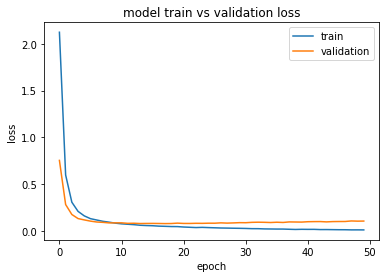

In [181]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

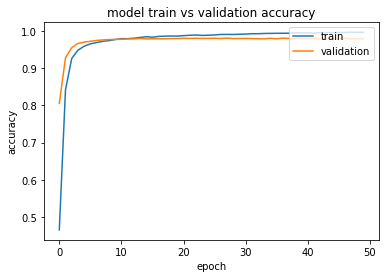

In [182]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [183]:
loss, acc = model.evaluate(X_dev_indices, Y_dev_oh)
print()
print("Test accuracy = ", acc)

399/399 [==============================] - 1s 3ms/step

Test accuracy =  0.979546124774


You should get a test accuracy of about 94.8% for a vanilla model using only aa1.txt.
A vanilla POS model on the full training set gets a dev accuracy of 98.50%!

In [78]:
def plot_confusion_matrix(y_actu, y_pred, title='Confusion matrix', cmap=plt.cm.gray_r):
    
    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)


In [79]:
X_dev_indices = lists_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_dev_indices)

# print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
# print(pd.crosstab(Y_dev, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_dev, pred)

ValueError: cannot reshape array of size 250096 into shape (98,)

In [184]:
# This code allows you to see the mislabelled examples

y_dev_oh = to_categorical(Y_dev_indices, num_classes = numClasses)
X_dev_indices = lists_to_indices(X_dev, word_to_index, maxLen)
pred = model.predict(X_dev_indices)

correct = 0
wrong = 0


for i in range(len(X_dev)-1):
    for j in range(len(X_dev[i])):
        num = np.argmax(pred[i][j])
        if(num != Y_dev_indices[i][j]):
            wrong = wrong + 1
            print('Expected POS tag: '+ X_dev[i][j] + '|' + Y_dev[i][j] + ' prediction: '+ X_dev[i][j] + '|' + index_to_pos2[num])
        else:
            correct = correct + 1
total = wrong + correct
print("Total  : ", total)
print("Correct: ", correct)
print("Wrong  : ", wrong)

cpct = (100*correct)/total
wpct = (100*wrong)/total
print("Correct %: ", cpct)
print("Wrong   %: ", wpct)

Expected POS tag: Britannnique|NOM prediction: Britannnique|NAM
Expected POS tag: pourquoi|ADV prediction: pourquoi|KON
Expected POS tag: Naître|NAM prediction: Naître|VER:infi
Expected POS tag: grandir|NAM prediction: grandir|VER:infi
Expected POS tag: issue|VER:pper prediction: issue|NOM
Expected POS tag: comme|ADV prediction: comme|KON
Expected POS tag: portable|ADJ prediction: portable|NOM
Expected POS tag: [|PUN prediction: [|ADJ
Expected POS tag: le|PRO:PER prediction: le|DET:ART
Expected POS tag: est|NOM prediction: est|VER:pres
Expected POS tag: les|PRO:PER prediction: les|DET:ART
Expected POS tag: que|KON prediction: que|PRO:REL
Expected POS tag: améliorera|VER:futu prediction: améliorera|VER:pres
Expected POS tag: toute|PRO:IND prediction: toute|ADV
Expected POS tag: s'|KON prediction: s'|PRO:PER
Expected POS tag: Intercontinental|NAM prediction: Intercontinental|ADJ
Expected POS tag: n|ABR prediction: n|KON
Expected POS tag: plein|ADJ prediction: plein|ADV
Expected POS tag: 

### POStagger results on development set

| tagset | LTSM units | batchnorm | dropout | epochs | results |
|:-----|---------:|:----------:|-------:|-----:|----------:|
| tt | 128 | no | 0 |  50 | 98.50 |


In [ ]:
model.save('tt_pos.h5')

## 5. Training the Supertagger

We split the data as before, only using Z (supertags) instead of Y2 (treetagger POStag set) as the goal

In [185]:
# split the training data into the standard 60% train, 20% dev, 20% test 
X_train, X_testdev, Y_super_train, Y_super_testdev = train_test_split(X, Z, test_size=0.4)
X_test, X_dev, Y_super_test, Y_super_dev = train_test_split(X_testdev, Y_super_testdev, test_size=0.5)
print("Train: ", X_train.shape)
print("Test:  ", X_test.shape)
print("Dev:   ", X_dev.shape)

Train:  (1195,)
Test:   (398,)
Dev:    (399,)


In [186]:
# Super_model

def Super_model(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # returning a batch of sequences.
    X = LSTM(256, return_sequences=True)(embeddings) 
    X = BatchNormalization()(X)
    X = Dropout(0.5)(X)
    
    # Add a (time distributed) Dense layer followed by a softmax activation
    X = TimeDistributed(Dense(numSuperClasses, activation='softmax'))(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices,outputs=X)
        
    return model

In [187]:
supermodel = Super_model((maxLen,), word_to_vec_map, word_to_index)
supermodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 119)               0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 119, 514)          5154392   
_________________________________________________________________
lstm_8 (LSTM)                (None, 119, 256)          789504    
_________________________________________________________________
batch_normalization_8 (Batch (None, 119, 256)          1024      
_________________________________________________________________
dropout_8 (Dropout)          (None, 119, 256)          0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 119, 518)          133126    
Total params: 6,078,046
Trainable params: 923,142
Non-trainable params: 5,154,904
____________________________________________________________

In [188]:
supermodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [189]:
X_train_indices = lists_to_indices(X_train, word_to_index, maxLen)
Y_super_train_indices = lists_to_indices(Y_super_train, super_to_index, maxLen)
Y_super_train_oh = to_categorical(Y_super_train_indices, num_classes=numSuperClasses)

In [190]:
print(Y_super_train_indices[2][1])
print(Y_super_train_oh[2][1])

151.0
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

In [191]:
X_dev_indices = lists_to_indices(X_dev, word_to_index, max_len = maxLen)
Y_super_dev_indices = lists_to_indices(Y_super_dev, super_to_index, max_len = maxLen)
Y_super_dev_oh = to_categorical(Y_super_dev_indices, num_classes = numSuperClasses)

In [ ]:
history = supermodel.fit(X_train_indices, Y_super_train_oh, epochs = 10, batch_size = 32, shuffle=True, validation_data=(X_dev_indices,Y_super_dev_oh))

Train on 1195 samples, validate on 399 samples
Epoch 1/10
1195/1195 [==============================] - 32s 26ms/step - loss: 3.3019 - acc: 0.4030 - val_loss: 1.8131 - val_acc: 0.6343
Epoch 2/10
1195/1195 [==============================] - 30s 25ms/step - loss: 1.5950 - acc: 0.6687 - val_loss: 1.2682 - val_acc: 0.7170
Epoch 3/10
1195/1195 [==============================] - 30s 25ms/step - loss: 1.1998 - acc: 0.7246 - val_loss: 1.0687 - val_acc: 0.7463
Epoch 4/10
1195/1195 [==============================] - 30s 25ms/step - loss: 1.0145 - acc: 0.7477 - val_loss: 0.9702 - val_acc: 0.7557
Epoch 5/10
1195/1195 [==============================] - 33s 28ms/step - loss: 0.8975 - acc: 0.7683 - val_loss: 0.9093 - val_acc: 0.7685
Epoch 6/10
1195/1195 [==============================] - 32s 27ms/step - loss: 0.8281 - acc: 0.7804 - val_loss: 0.9237 - val_acc: 0.7716
Epoch 7/10
1195/1195 [==============================] - 32s 27ms/step - loss: 0.7688 - acc: 0.7898 - val_loss: 0.8619 - val_acc: 0.7747
E

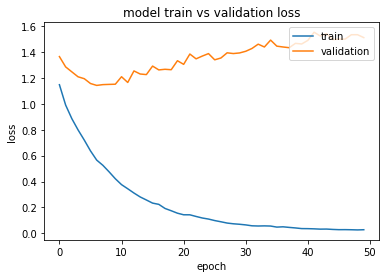

In [89]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

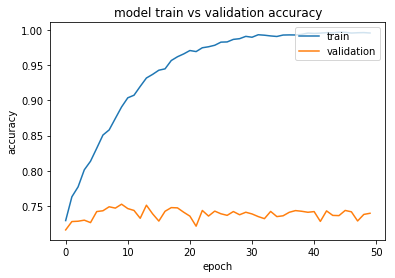

In [90]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
loss, acc = supermodel.evaluate(X_dev_indices, Y_super_dev_oh)
print()
print("Test accuracy = ", acc)

In [ ]:
supermodel.save('supertagger.h5')

### Supertagger results on development set

| LTSM units | batchnorm | dropout | epochs | results |
|---------:|:----------:|-------:|----:|----------:|
| 128 | yes | .2 |  50 | 80.21 |
| 256 | yes | .2 |  50 | |